In [1]:
import sys
sys.path.append('../..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from scipy import interpolate

import random
import tqdm
from copy import deepcopy
from argparse import Namespace
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from causal_meta.modules import networks as nets
from causal_meta.utils.data_utils import RandomSplineSCM

import train_utils as tu
from xcoders import Rotor
from mixture_density import MDN, GMM, mdn_nll
from gmm import GaussianMixture

In [4]:
SEED = 91023
torch.manual_seed(SEED)
np.random.seed(SEED)

# Boilerplate

## Utilities

In [5]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)

def normal_like(X): 
    mean = X.mean()
    std = X.std()
    return normal(mean, std, X.size(0))

def mlp(opt): 
    if opt.NUM_MID_LAYERS == -1: 
        return nn.Linear(opt.INP_DIM, opt.OUT_DIM)
    else:
        return nets.MLP(opt.INP_DIM, opt.OUT_DIM, opt.NUM_MID_LAYERS, 
                        opt.CAPACITY, opt.INP_NOISE)

## Mixture Density

In [6]:
def mdn(opt): 
    return MDN(opt.CAPACITY, opt.NUM_COMPONENTS)

def gmm(opt): 
    return GaussianMixture(opt.GMM_NUM_COMPONENTS)

## Reversible Encoder

In [7]:
def xcodergen(opt): 
    # Make rotor
    return Rotor(opt.XCODER_INIT)

## Ground Truth Generator

We use a posterior of the form: 

$$
P(Y | X) = \sum_i \pi_i(X) \mathcal{N}(\mu_i(X), \sigma_i(X))
$$

which is a mixture of 10 gaussians. 

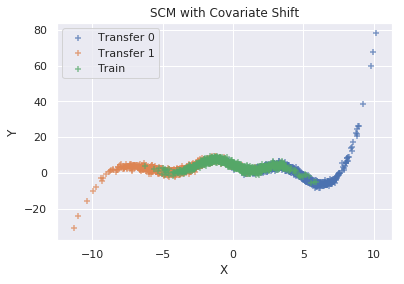

In [8]:
# Test
rand_scm = RandomSplineSCM(False, True, 8, 8, 3, range_scale=1.)

plt.figure()
plt.title("SCM with Covariate Shift")
rand_scm.plot(X=normal(4, 2, 1000), show=False, label='Transfer 0', alpha=0.7)
rand_scm.plot(X=normal(-4, 2, 1000), show=False, label='Transfer 1', alpha=0.7)
rand_scm.plot(X=normal(0, 2, 1000), show=False, label='Train', alpha=0.7)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## Visualization

In [9]:
def plot_key(frames, key, show=True, label=None, name=None): 
    its, vals = zip(*[(frame.iter_num, getattr(frame, key)) for frame in frames])
    if show:
        plt.figure()
    plt.plot(its, vals, label=label)
    if show:
        plt.xlabel("Iterations")
        plt.ylabel(name if name is not None else key.title())
        plt.show()

## Training

In [10]:
def gradnan_filter(model): 
    nan_found = False
    for p in model.parameters(): 
        nan_mask = torch.isnan(p.grad.data)
        nan_found = bool(nan_mask.any().item())
        p.grad.data[nan_mask] = 0.
    return nan_found

In [11]:
def marginal_nll(opt, inp, nll): 
    model_g = gmm(opt)
    if opt.CUDA: 
        model_g = model_g.cuda()
    model_g.fit(inp, n_iter=opt.EM_ITERS)
    with torch.no_grad():
        loss_marginal = nll(model_g(inp), inp)
    return loss_marginal

In [13]:
def encoder_train_shared_regret(opt, model_x2y, model_y2x, scm, encoder, decoder, alpha): 
    if opt.CUDA: 
        model_x2y = model_x2y.cuda()
        model_y2x = model_y2x.cuda()
        encoder = encoder.cuda()
        decoder = decoder.cuda()
    encoder_optim = torch.optim.Adam(encoder.parameters(), opt.ENCODER_LR)
    alpha_optim = torch.optim.Adam([alpha], opt.ALPHA_LR)
    frames = []
    for meta_iter in tqdm.trange(opt.NUM_META_ITER): 
        # Preheat the models
        _ = tu.train_nll(opt, model_x2y, scm, opt.TRAIN_DISTRY, 'X2Y', 
                         mdn_nll, decoder, encoder, quiet=True)
        _ = tu.train_nll(opt, model_y2x, scm, opt.TRAIN_DISTRY, 'Y2X', 
                         mdn_nll, decoder, encoder, quiet=True)
        # Sample from SCM
        X = opt.TRANS_DISTRY()
        Y = scm(X)
        if opt.CUDA: 
            X, Y = X.cuda(), Y.cuda()
        # Decode 
        with torch.no_grad(): 
            X, Y = decoder(X, Y)
        # Encode
        X, Y = encoder(X, Y)
        with torch.no_grad():
            if opt.USE_BASELINE:
                baseline_y = marginal_nll(opt, Y, mdn_nll)
                baseline_x = marginal_nll(opt, X, mdn_nll)
            else:
                baseline_y = 0.
                baseline_x = 0.
        # Save state dicts
        state_x2y = deepcopy(model_x2y.state_dict())
        state_y2x = deepcopy(model_y2x.state_dict())
        # Inner loop 
        optim_x2y = torch.optim.Adam(model_x2y.parameters(), lr=opt.FINETUNE_LR)
        optim_y2x = torch.optim.Adam(model_y2x.parameters(), lr=opt.FINETUNE_LR)
        regrets_x2y = []
        regrets_y2x = []
        is_nan = False
        # Evaluate regret discrepancy 
        for t in range(opt.FINETUNE_NUM_ITER):
            loss_x2y = mdn_nll(model_x2y(X), Y)
            loss_y2x = mdn_nll(model_y2x(Y), X)
            if torch.isnan(loss_x2y).item() or torch.isnan(loss_y2x).item(): 
                is_nan = True
                break
            optim_x2y.zero_grad()
            optim_y2x.zero_grad()
            loss_x2y.backward(retain_graph=True) 
            loss_y2x.backward(retain_graph=True)
            # Filter out NaNs that might have sneaked in
            nan_in_x2y = gradnan_filter(model_x2y)
            nan_in_y2x = gradnan_filter(model_y2x)
            if nan_in_x2y or nan_in_y2x: 
                is_nan = True
                break
            optim_x2y.step()
            optim_y2x.step()
            # Store for encoder
            regrets_x2y.append(loss_x2y + baseline_x)
            regrets_y2x.append(loss_y2x + baseline_y)
        if not is_nan:
            # Evaluate total regret
            regret_x2y = torch.stack(regrets_x2y).mean()
            regret_y2x = torch.stack(regrets_y2x).mean()
            # Evaluate losses
            loss = torch.logsumexp(
                torch.stack([F.logsigmoid(alpha) + regret_x2y,
                             F.logsigmoid(-alpha) + regret_y2x]), 
                0)
            # Optimize
            encoder_optim.zero_grad()
            alpha_optim.zero_grad()
            loss.backward()
            # Make sure no nans
            if torch.isnan(encoder.theta.grad.data).any(): 
                encoder.theta.grad.data.zero_()
            if torch.isnan(alpha.grad.data).any(): 
                alpha.grad.data.zero_()
            encoder_optim.step()
            alpha_optim.step()
            # Load original state dicts
            model_x2y.load_state_dict(state_x2y)
            model_y2x.load_state_dict(state_y2x)
            # Add info
            frames.append(Namespace(iter_num=meta_iter, 
                                    regret_x2y=regret_x2y.item(), 
                                    regret_y2x=regret_y2x.item(),
                                    loss=loss.item(),
                                    alpha=alpha.item(), 
                                    theta=encoder.theta.item()))
        else:
            # Load original state dicts
            model_x2y.load_state_dict(state_x2y)
            model_y2x.load_state_dict(state_y2x)
            # Add dummy info
            frames.append(Namespace(iter_num=meta_iter, 
                                    regret_x2y=float('nan'), 
                                    regret_y2x=float('nan'),
                                    loss=float('nan'),
                                    alpha=float('nan'), 
                                    theta=float('nan')))
            
    return frames

In [14]:
def plot_theta(frames, gt_theta, save=False): 
    its, vals = zip(*[(frame.iter_num, frame.theta / (np.pi / 2)) for frame in frames])
    gt_theta = -gt_theta.item() / (np.pi / 2)
    plt.figure()
    # plt.plot(its, vals, label=r'$\theta_{\mathcal{E}}$', c='black')
    plt.plot(its, vals, label=r'$\theta_{\mathcal{E}}$')
    plt.plot(its, [gt_theta] * len(its), linestyle='--', label=r'Solution 1 $\left(+\frac{\pi}{4}\right)$')
    plt.plot(its, [gt_theta - 1] * len(its), linestyle='--', label=r'Solution 2 $\left(-\frac{\pi}{4}\right)$')
    plt.xlabel("Iterations")
    plt.ylabel("Encoder Angle [π/2 rad]")
    plt.legend()
    if save:
        plt.savefig('fixed-encoder-evo.pdf', bbox_inches='tight', format='pdf')
    plt.show()

In [15]:
def probe_xcoders(encoder, decoder):
    # Test encoder and decoder
    with torch.no_grad():
        _X = torch.tensor([[1.]])
        _Y = torch.tensor([[0.]])
        if opt.CUDA:
            _X, _Y = _X.to(encoder.theta.device), _Y.to(encoder.theta.device)
        _X_d, _Y_d = decoder(_X, _Y)
        _X_de, _Y_de = encoder(_X_d, _Y_d)
    print(f"Initial (A, B) = {_X.item()}, {_Y.item()}")
    print(f"Decoded (X, Y) = {_X_d.item()}, {_Y_d.item()}")
    print(f"Encoded (U, V) = {_X_de.item()}, {_Y_de.item()}")

# Experiments with Unfixed Encoders

In [16]:
opt = Namespace()

# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 10
opt.GMM_NUM_COMPONENTS = 10

# Training
opt.LR = 0.01
opt.NUM_ITER = 20
opt.NUM_META_ITER = 1000
opt.ENCODER_LR = 0.01
opt.ALPHA_LR = 0.001
opt.CUDA = True
opt.REC_FREQ = 10
opt.ALPHA_INIT = 0.
opt.USE_BASELINE = True

# Fine tuning
opt.FINETUNE_NUM_ITER = 5
opt.FINETUNE_LR = 0.001
opt.EM_ITERS = 500

# Sampling 
opt.NUM_SAMPLES = 1000
opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
opt.TRANS_DISTRY = lambda: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_SAMPLES)

# Encoder
opt.DECODER_DEFAULT = -float(0.5 * np.pi/2)

## Make Xcoders

Make a ground-truth decoder with $\theta_0$. 

In [17]:
gt_decoder = Rotor(opt.DECODER_DEFAULT)

The real encoder should have $\theta = -\theta_0$. 

In [18]:
encoder = Rotor(0. * np.pi/2)

In [19]:
probe_xcoders(encoder, gt_decoder)

Initial (A, B) = 1.0, 0.0
Decoded (X, Y) = 0.7071067690849304, 0.7071067690849304
Encoded (U, V) = 0.7071067690849304, 0.7071067690849304


## Make Alpha and Models

In [20]:
alpha = tu.make_alpha(opt)

In [21]:
model_x2y = mdn(opt)
model_y2x = mdn(opt)

## Train Encoder

If it doesn't work with the seed of your choice, try tuning the (hyper)parameters of ```opt.TRANS_DISTRY```. Since the SCM is generated randomly, it's not possible to know the correct hyper-parameters in advance (unless the seed is fixed). $\sigma \in (1, 2)$ should work fine, but if the range from which the means are sampled is too large, you can have numerical instabilities. If it's too small, the gradient signal to the encoder can be weak. 

In [22]:
frames = encoder_train_shared_regret(opt, model_x2y, model_y2x, rand_scm, encoder, gt_decoder, alpha)

100%|██████████| 1000/1000 [22:56<00:00,  1.80s/it]


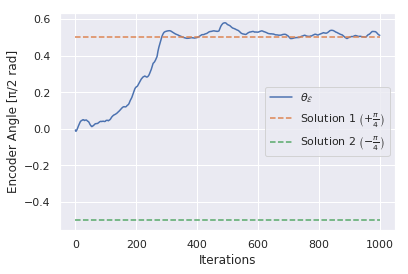

In [23]:
plot_theta(frames, gt_decoder.theta)

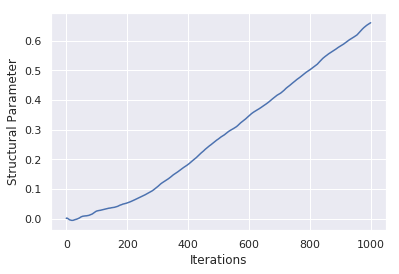

In [24]:
plot_key(frames, 'alpha', name='Structural Parameter')